<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Fraude_CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de fraudes à la carte bancaire

Cette base de données contient des transactions effectuées par CB en septembre 2013 par des utilisateurs européens. Les données ont été enregistrées sur deux jours, pendant lesquels 492 utilisations frauduleuses sur un total de 284 807 transactions ont été enregistrées.  

Ce ratio est fortement déséquilibré car les cas de fraudes ne représentent que 0.172% des transactions. Un apprentissage supervisé n'est donc pas possible ici.  

Nous allons utiliser un auto-encodeur pour effectuer un apprentissage non supervisé afin de détecter des irrégularités dans les données, indices de fraudes.  

Les données sont disponibles sur le site de [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Lecture des données

Le nombre de données est très grand. Pour réduire le temps de calcul, nous n'utiliserons qu'une partie d'entre elles.  

In [2]:
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip?raw=true"
!unzip creditcard.zip -x

--2021-02-16 14:16:56--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip [following]
--2021-02-16 14:16:56--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip [following]
--2021-02-16 14:16:56--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 1

In [ ]:
!ls -l

In [3]:
data = pd.read_csv("creditcard.csv")
data = data.head(30000)
data.shape

(30000, 31)

Les colonnes qui ne sont pas anonymisées sont :
- Time : Temps écoulé depuis la première transaction
- Amount : Montant de la transaction
- Class : 0 = Achat non frauduleux / 1 = achat frauduleux
  
Les autres données anonymes sont par exemple les coordonnées de l'acheteur, son adresse, ...

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Regardons combien nous avons de données frauduleuses :

In [ ]:
data.groupby(['Class']).count()

In [ ]:
100*(94/29906)

## Préparation des données

La colonne Time tout d'abord ignorée

In [5]:
data = data.drop(['Time'], axis=1)

Ensuite, les montants des transactions sont normalisés en supprimant la valeur moyenne et en faisant en sorte que la variance soit égale à 1. Les autres colonnes sont inchangées.

count    30000.000000
mean        79.863644
std        222.686041
min          0.000000
25%          6.540000
50%         20.000000
75%         71.000000
max       7879.420000
Name: Amount, dtype: float64


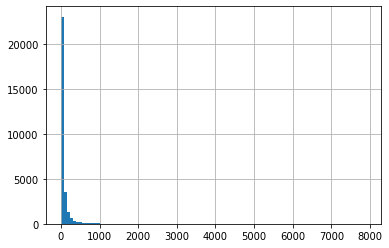

In [6]:
# Histogramme des montants avant normalisation

df = data['Amount']
print(df.describe())
df.hist(bins=100)

In [7]:
# Normalisation des montants

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

count    3.000000e+04
mean     5.547555e-16
std      1.000017e+00
min     -3.586438e-01
25%     -3.292746e-01
50%     -2.688298e-01
75%     -3.980398e-02
max      3.502548e+01
Name: Amount, dtype: float64


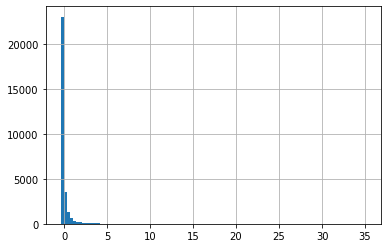

In [8]:
# Histogramme des montants après normalisation

df = data['Amount']
print(df.describe())
df.hist(bins=100)

In [9]:
# Séparation des données d'entrainement et de test

x_entrainement, x_test = train_test_split(data, test_size=0.2, random_state=0)
x_entrainement = x_entrainement.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_entrainement = x_entrainement.values
x_test = x_test.values
x_entrainement.shape

(24000, 29)

## Construction du modèle

Ce modèle est un modèle standard d'auto-encodeur à quatre couches :
- Une couche d'entrée à 14 neurones, avec une fonction d'activation de type tanh
- Une première couche cachées de 14/2 = 7 neurones, avec une fonction d'activation de type relu
- Une deuxième couche cachée de 14/2 = 7 neurones, avec une fonction d'activation de type tanh
- Une couche de sortie à 29 neurones (même dimension que les données d'entrées), avec une fonction d'activation de type relu

La structure de notre modèle peut être visualisée comme ci-dessous :  
![picture](https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Schema_Non_Supervis%C3%A932.png?raw=true "ReseauNeurone")

In [10]:
dimension_entrees = x_entrainement.shape[1]
dimension_encodeur = 14

model = Sequential()
model.add(Dense(dimension_encodeur, activation="tanh", input_shape=(dimension_entrees,)))
model.add(Dense(int(dimension_encodeur /2), activation="relu"))
model.add(Dense(int(dimension_encodeur /2), activation='tanh'))
model.add(Dense(dimension_entrees, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


# Entrainement du modèle



In [11]:
nb_iterations = 50
batch_size = 30

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_entrainement, x_entrainement,
                    epochs=nb_iterations,
                    batch_size=batch_size,
                    validation_data=(x_test, x_test),
                    verbose=1)

autoencoder = model

Epoch 1/50
800/800 [==============================] - 3s 2ms/step - loss: 1.1469 - acc: 0.2440 - val_loss: 0.9711 - val_acc: 0.5153
Epoch 2/50
800/800 [==============================] - 1s 2ms/step - loss: 1.0112 - acc: 0.5285 - val_loss: 0.9131 - val_acc: 0.5595
Epoch 3/50
800/800 [==============================] - 2s 2ms/step - loss: 0.9711 - acc: 0.5658 - val_loss: 0.8810 - val_acc: 0.5953
Epoch 4/50
800/800 [==============================] - 1s 2ms/step - loss: 0.9329 - acc: 0.5961 - val_loss: 0.8668 - val_acc: 0.6052
Epoch 5/50
800/800 [==============================] - 1s 2ms/step - loss: 0.8493 - acc: 0.6086 - val_loss: 0.8567 - val_acc: 0.6062
Epoch 6/50
800/800 [==============================] - 1s 1ms/step - loss: 0.9036 - acc: 0.6082 - val_loss: 0.8473 - val_acc: 0.6198
Epoch 7/50
800/800 [==============================] - 1s 1ms/step - loss: 0.8626 - acc: 0.6262 - val_loss: 0.8364 - val_acc: 0.6318
Epoch 8/50
800/800 [==============================] - 2s 2ms/step - loss: 0.

## Performances du modèle


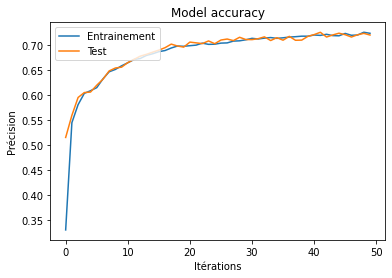

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

## Structure du modèle et calcul de l'erreur de prédiction
La structure de notre modèle peut être visualisée comme ci-dessous :  
![picture](https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Schema_Non_Supervis%C3%A932.png?raw=true "ReseauNeurone")

L'erreur de prédiction est l'erreur quadratique moyenne entre les entrées et les sorties (écart type). Pour chaque couple d'entrée / sortie, on calcule donc la valeur suivante :

 $Erreur =  \sqrt {{{({V_{1{\rm{\_sortie}}}} - {V_{1{\rm{\_entr}}e }})}^2} + {{({V_{2{\rm{\_sortie}}}} - {V_{2{\rm{\_entr}}e }})}^2} + ... + {{(Amoun{t_{{\rm{\_sortie}}}} - Amoun{t_{{\rm{\_entr}}e }})}^2}} $

In [13]:
x_test

array([[-3.61552232e-01,  5.37903469e-01,  1.99185075e+00, ...,
        -2.20350809e-01, -4.42348047e-02, -2.87017133e-01],
       [-2.25940517e+00,  1.89373934e+00,  1.26869060e+00, ...,
        -1.59792945e-01, -1.32048624e-01, -2.72916329e-01],
       [-6.67139522e-01,  9.59516941e-01,  2.42797161e+00, ...,
        -6.70494168e-01, -3.11756735e-01, -2.67976557e-01],
       ...,
       [-7.34151857e-01,  1.09726690e+00,  2.59526169e+00, ...,
         1.25185194e-02,  1.58217856e-01, -3.58643831e-01],
       [-3.25562469e-01,  9.54274786e-01,  2.36701572e+00, ...,
         7.07424326e-02,  3.76715989e-02, -3.38166230e-01],
       [-1.08847881e+01, -1.34496840e+01, -1.56693680e+00, ...,
         1.93615207e+00, -1.37972779e+00,  3.90119125e+00]])

## Prédictions

Les prédictions sont effectuées sur les données de tests. L'erreur quadratique moyenne (mean-squared error - MSE) est calculés entre les tests et les prédictions. Si cette erreur est grande, c'est une potentielle anomalie et donc une fraude potentielle. Bien sûr, cela n'est pas parfait et il y a des faux-positifs (et des faux négatifs) !

In [14]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'erreur_reconstruction': mse, 'class': y_test})

In [ ]:
x_test.shape

In [16]:
predictions
mse

array([ 0.32364438,  0.79623792,  0.33272834, ...,  0.35478866,
        0.19909871, 16.59191957])

In [18]:
error_df.head()

,erreur_reconstruction,class
8225,0.323644,0
10794,0.796238,0
9163,0.332728,0
26591,0.160957,0
6631,0.437355,0


## Affichage de l'erreur de reconstruction

L'erreur de reconstruction est affichée pour chaque échantillon. Seuls 6000 échantillons sont affichés, mais les données affichées sont tirées au hasard.

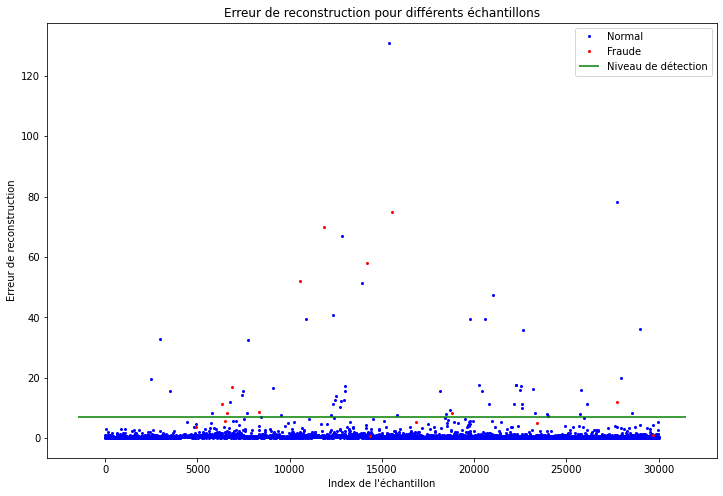

In [20]:
niveau_detection = 7

groups = error_df.groupby('class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.erreur_reconstruction, marker='o', ms=2.0, linestyle='',
            label = "Fraude" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(niveau_detection, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Niveau de détection')
ax.legend()
plt.title("Erreur de reconstruction pour différents échantillons")
plt.ylabel("Erreur de reconstruction")
plt.xlabel("Index de l'échantillon")
plt.show();

# Analyse

Comme nous connaissons les transactions frauduleuses, nous pouvons afficher et calculer le nombre de faux positifs. Dans l'idéal, il faudrait que leur nombre soit très faible, mais notre modèle est imparfait... 

In [ ]:
transactions_normales = error_df[error_df['class'] == 0]
transactions_frauduleuses = error_df[error_df['class'] == 1]

print('Transactions normales : %d, Transactions frauduleuse : %d' % (len(transactions_normales), len(transactions_frauduleuses)))

In [ ]:
vraies_transactions_frauduleuses = len(transactions_frauduleuses[transactions_frauduleuses['erreur_reconstruction'] >= niveau_detection])
vraies_transactions_normales = len(transactions_normales[transactions_normales['erreur_reconstruction'] < niveau_detection])

faux_positifs = len(transactions_normales[transactions_normales['erreur_reconstruction'] >= niveau_detection])
faux_negatifs = len(transactions_frauduleuses[transactions_frauduleuses['erreur_reconstruction'] < niveau_detection])

print('Faux positifs: %d, Vraies transactions frauduleuses: %d' % (faux_positifs, vraies_transactions_frauduleuses))
print('Faux négatifs : %d, Vraies transactions normales: %d' % (faux_negatifs, vraies_transactions_normales))

## Matrice de synthèse

La matrice de synthèse ci-dessous permet d'avoir une vue d'ensemble des résultats obtenus.

In [ ]:
labels = ["Normale", "Fraude"]

y_pred = [1 if e > niveau_detection else 0 for e in error_df.erreur_reconstruction.values]
conf_matrix = confusion_matrix(error_df['class'], y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Matrice de synthèse")
plt.ylabel('Cas réels')
plt.xlabel('Prédictions')
plt.show()